## Code adapted from https://github.com/maziarraissi/PINNs

In [ ]:
pip install pyDOE

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving newdata_05.mat to newdata_05.mat


In [ ]:
%tensorflow_version 1.x  

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, y0, x20, y20, u0, v0, u20, v20, tb1, tb2, x_m, y_m, tm, X_f, X_f2, layers, lb, ub, lb2, ub2):
        
        m=0.5
        X0 = np.concatenate((x0, y0, 0*x0), 1)
        X20 = np.concatenate((x20, y20, 0*x20), 1) # (x0, 0)
        lb = np.array([0.0, 0.0, 0.0])
        ub = np.array([0.5, 1000.0, 1.0])

        lb2 = np.array([0.5, 0.0, 0.0])
        ub2 = np.array([1.0, 1000.0, 1.0])

        X_lb_1 = np.concatenate((0*tb1 + lb[0], y_b1, tb1), 1) # (0, y , t) 
        X_ub_1 = np.concatenate((0*tb2 + ub2[0], y_b1, tb1), 1) # (1, y, t)

        X_lb_2 = np.concatenate((x_b1, 0*tb2+ lb[1], tb2), 1) # (x, 0, t) , 1st layer
        X_ub_2 = np.concatenate((x_b1, 0*tb2 + ub2[1], tb2), 1) # (x, 10, t), 1st layer
        
        X_lb_3 = np.concatenate((x_b1, 0*tb2 + lb[1], tb2), 1) # (x, 0, t), 2nd layer
        X_ub_3 = np.concatenate((x_b1, 0*tb2 + ub2[1], tb2), 1) # (x, 10, t), 2nd layer

        X_m = np.concatenate((x_m, y_m, tm), 1) # (lb[0], tb)
        
        self.lb = lb
        self.ub = ub

        self.lb2 = lb2
        self.ub2 = ub2


        self.x0 = X0[:,0:1]
        self.y0 = X0[:,1:2]
        self.t0 = X0[:,2:3]

        self.x20 = X20[:,0:1]
        self.y20 = X20[:,1:2]
        self.t20 = X20[:,2:3]

        self.x_lb1 = X_lb_1[:,0:1]
        self.y_lb1 = X_lb_1[:,1:2]
        self.t_lb1 = X_lb_1[:,2:3]

        self.x_ub1 = X_ub_1[:,0:1]
        self.y_ub1 = X_ub_1[:,1:2]
        self.t_ub1 = X_ub_1[:,2:3]
        
        self.x_lb2 = X_lb_2[:,0:1]
        self.y_lb2 = X_lb_2[:,1:2]
        self.t_lb2 = X_lb_2[:,2:3]

        self.x_lb3 = X_lb_3[:,0:1]
        self.y_lb3 = X_lb_3[:,1:2]
        self.t_lb3 = X_lb_3[:,2:3]

        self.x_ub2 = X_ub_2[:,0:1]
        self.y_ub2 = X_ub_2[:,1:2]
        self.t_ub2 = X_ub_2[:,2:3]

        self.x_ub3 = X_ub_3[:,0:1]
        self.y_ub3 = X_ub_3[:,1:2]
        self.t_ub3 = X_ub_3[:,2:3]

        self.x_m = X_m[:,0:1]
        self.y_m = X_m[:,1:2]
        self.t_m = X_m[:,2:3]
        
        self.x_f = X_f[:,0:1]
        self.y_f = X_f[:,1:2]
        self.t_f = X_f[:,2:3]
        
        self.x2_f = X_f2[:,0:1]
        self.y2_f = X_f2[:,1:2]
        self.t2_f = X_f2[:,2:3]

        self.u0 = u0
        self.v0 = v0

        self.u20 = u20
        self.v20 = v20

        k1 = 1.26E-05
        k2 = 3.76E-06

        # Initialize NNs
        self.layers = layers
        self.weights_u, self.biases_u = self.initialize_NN_u(layers)
        self.weights_v, self.biases_v = self.initialize_NN_v(layers)
        
        self.weights_u2, self.biases_u2 = self.initialize_NN_u2(layers)
        self.weights_v2, self.biases_v2 = self.initialize_NN_v2(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y0_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.x20_tf = tf.placeholder(tf.float32, shape=[None, self.x20.shape[1]])
        self.y20_tf = tf.placeholder(tf.float32, shape=[None, self.y20.shape[1]])
        self.t20_tf = tf.placeholder(tf.float32, shape=[None, self.t20.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])

        self.u20_tf = tf.placeholder(tf.float32, shape=[None, self.u20.shape[1]])
        self.v20_tf = tf.placeholder(tf.float32, shape=[None, self.v20.shape[1]])
        
        
        self.x_lb1_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb1.shape[1]])
        self.y_lb1_tf = tf.placeholder(tf.float32, shape=[None, self.y_lb1.shape[1]])
        self.t_lb1_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb1.shape[1]])
        
        self.x_ub1_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub1.shape[1]])
        self.y_ub1_tf = tf.placeholder(tf.float32, shape=[None, self.y_ub1.shape[1]])
        self.t_ub1_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub1.shape[1]])
        
        self.x_lb2_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb2.shape[1]])
        self.y_lb2_tf = tf.placeholder(tf.float32, shape=[None, self.y_lb2.shape[1]])
        self.t_lb2_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb2.shape[1]])
        
        self.x_lb3_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb3.shape[1]])
        self.y_lb3_tf = tf.placeholder(tf.float32, shape=[None, self.y_lb3.shape[1]])
        self.t_lb3_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb3.shape[1]])
        
        self.x_ub2_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub2.shape[1]])
        self.y_ub2_tf = tf.placeholder(tf.float32, shape=[None, self.y_ub2.shape[1]])
        self.t_ub2_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub2.shape[1]])
        
        self.x_ub3_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub3.shape[1]])
        self.y_ub3_tf = tf.placeholder(tf.float32, shape=[None, self.y_ub3.shape[1]])
        self.t_ub3_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub3.shape[1]])
        
        self.x_m_tf = tf.placeholder(tf.float32, shape=[None, self.x_m.shape[1]])
        self.y_m_tf = tf.placeholder(tf.float32, shape=[None, self.y_m.shape[1]])
        self.t_m_tf = tf.placeholder(tf.float32, shape=[None, self.t_m.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, self.y_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        self.x2_f_tf = tf.placeholder(tf.float32, shape=[None, self.x2_f.shape[1]])
        self.y2_f_tf = tf.placeholder(tf.float32, shape=[None, self.y2_f.shape[1]])
        self.t2_f_tf = tf.placeholder(tf.float32, shape=[None, self.t2_f.shape[1]])


        self.um_pred, self.u_x_m_pred, _ = self.net_u(self.x_m_tf, self.y_m_tf, self.t_m_tf)
        self.vm_pred, self.v_x_m_pred, _ = self.net_v(self.x_m_tf, self.y_m_tf, self.t_m_tf)
        
        self.u2m_pred, self.u2_x_m_pred, _ = self.net_u2(self.x_m_tf, self.y_m_tf, self.t_m_tf)
        self.v2m_pred, self.v2_x_m_pred, _ = self.net_v2(self.x_m_tf, self.y_m_tf, self.t_m_tf)

        self.u0_pred, _, _ = self.net_u(self.x0_tf, self.y0_tf, self.t0_tf)
        self.v0_pred, _, _ = self.net_v(self.x0_tf, self.y0_tf, self.t0_tf)
        self.u20_pred, _, _ = self.net_u2(self.x20_tf, self.y20_tf, self.t20_tf)
        self.v20_pred, _, _ = self.net_v2(self.x20_tf, self.y20_tf, self.t20_tf)
        
        _, self.u_x_lb1_pred, _ = self.net_u(self.x_lb1_tf, self.y_lb1_tf, self.t_lb1_tf)
        _, self.v_x_lb1_pred, _ = self.net_v(self.x_lb1_tf, self.y_lb1_tf, self.t_lb1_tf)
        _, self.u2_x_ub1_pred, _ = self.net_u2(self.x_ub1_tf, self.y_ub1_tf, self.t_ub1_tf)
        _, self.v2_x_ub1_pred, _ = self.net_v2(self.x_ub1_tf, self.y_ub1_tf, self.t_ub1_tf)
        _, _, self.u_y_lb2_pred = self.net_u(self.x_lb2_tf, self.y_lb2_tf, self.t_lb2_tf)
        _, _, self.v_y_lb2_pred = self.net_v(self.x_lb2_tf, self.y_lb2_tf, self.t_lb2_tf)
        _, _, self.u2_y_lb3_pred = self.net_u2(self.x_lb3_tf, self.y_lb3_tf, self.t_lb3_tf)
        _, _, self.v2_y_lb3_pred = self.net_v2(self.x_lb3_tf, self.y_lb3_tf, self.t_lb3_tf)
        _, _, self.u_y_ub2_pred = self.net_u(self.x_ub2_tf, self.y_ub2_tf, self.t_ub2_tf)
        _, _, self.v_y_ub2_pred = self.net_v(self.x_ub2_tf, self.y_ub2_tf, self.t_ub2_tf)
        _, _, self.u2_y_ub3_pred = self.net_u2(self.x_ub3_tf, self.y_ub3_tf, self.t_ub3_tf)
        _, _, self.v2_y_ub3_pred = self.net_v2(self.x_ub3_tf, self.y_ub3_tf, self.t_ub3_tf)
        
        
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.y_f_tf, self.t_f_tf)
        self.f_u2_pred, self.f_v2_pred = self.net_f_uv2(self.x2_f_tf, self.y2_f_tf, self.t2_f_tf)
        
        C = 1
        # Loss
        self.loss = tf.reduce_mean(C*tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(C*tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(C*tf.square(self.u20_tf - self.u20_pred)) + \
                    tf.reduce_mean(C*tf.square(self.v20_tf - self.v20_pred)) + \
                    tf.reduce_mean(tf.square(self.um_pred - self.u2m_pred))+ \
                    tf.reduce_mean(tf.square(self.u_x_lb1_pred)) + tf.reduce_mean(tf.square(self.u2_x_ub1_pred )) +\
                    tf.reduce_mean(tf.square(self.v_x_lb1_pred)) + tf.reduce_mean(tf.square(self.v2_x_ub1_pred )) + \
                    tf.reduce_mean(tf.square(self.u_y_lb2_pred))+ tf.reduce_mean(tf.square(self.u2_y_lb3_pred))+ \
                    tf.reduce_mean(tf.square(self.u_y_ub2_pred))+ tf.reduce_mean(tf.square(self.u2_y_ub3_pred )) +\
                    tf.reduce_mean(tf.square(self.v_y_lb2_pred)) + tf.reduce_mean(tf.square(self.v2_y_lb3_pred)) +\
                    tf.reduce_mean(tf.square(self.v_y_ub2_pred)) + tf.reduce_mean(tf.square(self.v2_y_ub3_pred)) + \
                    tf.reduce_mean(tf.square(k1*((self.um_pred+1)/(self.vm_pred+1))*self.u_x_m_pred - k2*((self.u2m_pred+1)/(self.v2m_pred+1))*self.u2_x_m_pred)) +\
                    tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u2_pred)) + tf.reduce_mean(tf.square(self.f_v2_pred))
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN_u(self, layers):        
        weights_u = []
        biases_u = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_u = self.xavier_init(size=[layers[l], layers[l+1]])
            b_u = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_u.append(W_u)
            biases_u.append(b_u)        
        return weights_u, biases_u

    def initialize_NN_v(self, layers):        
        weights_v = []
        biases_v = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_v = self.xavier_init(size=[layers[l], layers[l+1]])
            b_v = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_v.append(W_v)
            biases_v.append(b_v)        
        return weights_v, biases_v    

    def initialize_NN_u2(self, layers):
        weights_u2 = []
        biases_u2 = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_u2 = self.xavier_init(size=[layers[l], layers[l+1]])
            b_u2 = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_u2.append(W_u2)
            biases_u2.append(b_u2)        
        return weights_u2, biases_u2

    def initialize_NN_v2(self, layers):        
        weights_v2 = []
        biases_v2 = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_v2 = self.xavier_init(size=[layers[l], layers[l+1]])
            b_v2 = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_v2.append(W_v2)
            biases_v2.append(b_v2)        
        return weights_v2, biases_v2        
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net_u(self, X, weights_u, biases_u):
        num_layers = len(weights_u) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W_u = weights_u[l]
            b_u = biases_u[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_u), b_u))
        W_u = weights_u[-1]
        b_u = biases_u[-1]
        Y = tf.add(tf.matmul(H, W_u), b_u)
        return Y
    
    def net_u(self, x, y, t):
        X = tf.concat([x, y, t],1)
        
        u = self.neural_net_u(X, self.weights_u, self.biases_u)
        
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]

        return u, u_x, u_y


    def neural_net_v(self, X, weights_v, biases_v):
        num_layers = len(weights_v) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W_v = weights_v[l]
            b_v = biases_v[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_v), b_v))
        W_v = weights_v[-1]
        b_v = biases_v[-1]
        Y = tf.add(tf.matmul(H, W_v), b_v)
        return Y

    def net_v(self, x, y, t):
        X = tf.concat([x, y, t],1)
        
        v = self.neural_net_v(X, self.weights_v, self.biases_v)
        
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]

        return v, v_x, v_y


    def net_f_uv(self, x, y, t):
        
        u, u_x, u_y = self.net_u(x, y, t)
        
        
        v, v_x, v_y = self.net_v(x, y, t)
        
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        ce=2.1E-5*(u+1)
        cl=2.5E-3
        G=1.04E-05
        k=1.26E-05
        tp=-0.5
        delta=0.153
        R=0.93
        J=0.006667
        sigma_bar = 10
        pow = x/delta + ((y-500)**2)/((sigma_bar)**2) +2.77*((t*0.4-2*tp*0.4-0.3)/(tp*0.4+0.3))**2
        sp = (0.94)*((1-R)/((tp*0.4+0.3)*delta))*J
        S= (sp/ce)*tf.math.exp(-pow)
        
        k_ce = k/ce
        
        f_u = u_t - k_ce*((u+1)/(v+1))*u_xx - k_ce*((u+1)/(v+1))*u_yy - (k_ce)*(u_x*(v+1)-v_x*(u+1))/((v+1)**2)*(u_x) - (k_ce)*(u_y*(v+1)-v_y*(u+1))/((v+1)**2)*(u_y) + (G/ce)*(u-v) - S
        
        f_v = v_t - (G/cl)*(u-v)

        return f_u, f_v

    def neural_net_u2(self, X, weights_u2, biases_u2):
        num_layers = len(weights_u2) + 1
        
        H = 2.0*(X - self.lb2)/(self.ub2 - self.lb2) - 1.0
        for l in range(0,num_layers-2):
            W_u2 = weights_u2[l]
            b_u2 = biases_u2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_u2), b_u2))
        W_u2 = weights_u2[-1]
        b_u2 = biases_u2[-1]
        Y = tf.add(tf.matmul(H, W_u2), b_u2)
        return Y
    
    def net_u2(self, x, y, t):
        X = tf.concat([x, y, t],1)
        
        u2 = self.neural_net_u2(X, self.weights_u2, self.biases_u2)
        
        u2_x = tf.gradients(u2, x)[0]
        u2_y = tf.gradients(u2, y)[0]
        
        return u2, u2_x, u2_y

    def neural_net_v2(self, X, weights_v2, biases_v2):
        num_layers = len(weights_v2) + 1
        
        H = 2.0*(X - self.lb2)/(self.ub2 - self.lb2) - 1.0
        for l in range(0,num_layers-2):
            W_v2 = weights_v2[l]
            b_v2 = biases_v2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_v2), b_v2))
        W_v2 = weights_v2[-1]
        b_v2 = biases_v2[-1]
        Y = tf.add(tf.matmul(H, W_v2), b_v2)
        return Y


    def net_v2(self, x, y, t):
        X = tf.concat([x, y, t],1)
        
        v2 = self.neural_net_v2(X, self.weights_v2, self.biases_v2)
        
        v2_x = tf.gradients(v2, x)[0]
        v2_y = tf.gradients(v2, y)[0]
        
        return v2, v2_x, v2_y
    
    
    def net_f_uv2(self, x, y, t):
        
        u2, u2_x, u2_y = self.net_u2(x, y, t)
        
        v2, v2_x, v2_y = self.net_v2(x, y, t)
        
        u2_t = tf.gradients(u2, t)[0]
        u2_xx = tf.gradients(u2_x, x)[0]
        u2_yy = tf.gradients(u2_y, y)[0]
        

        v2_t = tf.gradients(v2, t)[0]
        v2_xx = tf.gradients(v2_x, x)[0]
        v2_yy = tf.gradients(v2_y, y)[0]


        ce2=5.8E-5*(u2+1)
        cl2=3.3E-3
        G2 = 0.000168
        k2=3.76E-06
        tp=-0.5
        delta=0.153
        R=0.93
        J=0.006667
        sigma_bar = 10
        pow = x/delta + ((y-500)**2)/((sigma_bar)**2) + 2.77*((t*0.4-2*tp*0.4-0.3)/(tp*0.4+0.3))**2
        sp = (0.94)*((1-R)/((tp*0.4+0.3)*delta))*J
        S= (sp/ce2)*tf.math.exp(-pow)
        
        k_ce2 = k2/ce2
        
        f_u2 = u2_t - k_ce2*((u2+1)/(v2+1))*u2_xx - k_ce2*((u2+1)/(v2+1))*u2_yy - (k_ce2)*(u2_x*(v2+1)-v2_x*(u2+1))/((v2+1)**2)*(u2_x) - (k_ce2)*(u2_y*(v2+1)-v2_y*(u2+1))/((v2+1)**2)*(u2_y) + (G2/ce2)*(u2-v2) - S
        
        f_v2 = v2_t - (G2/cl2)*(u2-v2)

        return f_u2, f_v2
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.x20_tf: self.x20, self.t20_tf: self.t20,
                   self.y0_tf: self.y0, self.y20_tf: self.y20,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.u20_tf: self.u20, self.v20_tf: self.v20,
                   self.x_lb1_tf: self.x_lb1, self.y_lb1_tf: self.y_lb1,
                   self.t_lb1_tf: self.t_lb1, self.x_ub1_tf: self.x_ub1, 
                   self.y_ub1_tf: self.y_ub1, self.t_ub1_tf: self.t_ub1, 
                   self.x_lb2_tf: self.x_lb2, self.y_lb2_tf: self.y_lb2, 
                   self.t_lb2_tf: self.t_lb2, self.x_ub2_tf: self.x_ub2, 
                   self.y_ub2_tf: self.y_ub2, self.t_ub2_tf: self.t_ub2,
                   self.x_lb3_tf: self.x_lb3, self.y_lb3_tf: self.y_lb3, 
                   self.t_lb3_tf: self.t_lb3,self.x_ub3_tf: self.x_ub3, 
                   self.y_ub3_tf: self.y_ub3, self.t_ub3_tf: self.t_ub3, 
                   self.x_m_tf: self.x_m, self.y_m_tf: self.y_m, self.t_m_tf: self.t_m, 
                   self.x_f_tf: self.x_f, self.y_f_tf: self.y_f, self.t_f_tf: self.t_f,
                   self.x2_f_tf: self.x2_f, self.y2_f_tf: self.y2_f, self.t2_f_tf: self.t2_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 1000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star, X_star2):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.y0_tf: X_star[:,1:2], self.t0_tf: X_star[:,2:3]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.y_f_tf: X_star[:,1:2], self.t_f_tf: X_star[:,2:3]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)

        tf_dict = {self.x20_tf: X_star2[:,0:1], self.y20_tf: X_star2[:,1:2], self.t20_tf: X_star2[:,2:3]}
        
        u_star2 = self.sess.run(self.u20_pred, tf_dict)  
        v_star2 = self.sess.run(self.v20_pred, tf_dict)  
        
        
        tf_dict = {self.x2_f_tf: X_star2[:,0:1], self.y2_f_tf: X_star2[:,1:2], self.t2_f_tf: X_star2[:,2:3]}
        
        f_u_star2 = self.sess.run(self.f_u2_pred, tf_dict)
        f_v_star2 = self.sess.run(self.f_v2_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star, u_star2, v_star2, f_u_star2, f_v_star2
    
if __name__ == "__main__": 
     
    noise = 0.0        
    
    # Doman bounds
    lb = np.array([0.0, 0.0, 0.0])
    ub = np.array([0.5, 1000.0, 1.0])

    lb2 = np.array([0.5, 0.0, 0.0])
    ub2 = np.array([1.0, 1000.0, 1.0])

    N0 = 150
    Nb = 150
    Nm = 150
    N_f = 10000
    N_f2 = 10000
    
    
    layers = [3, 100, 100, 100, 100, 1]
        
    t = np.linspace(0.0,1.0,100).flatten()[:,None]
    data = scipy.io.loadmat('newdata_05.mat')
    ui = data['uu10'] # based on size of X_star
    ui = np.transpose(ui)
    vi = data['vv10'] # based on size of X_star
    vi = np.transpose(vi)
    u2i = data['uu20']
    u2i = np.transpose(u2i)
    v2i = data['vv20']
    v2i = np.transpose(v2i)
    y = np.linspace(0,1000,200).flatten()[:,None]
    x = np.linspace(0.0,0.5,300).flatten()[:,None]
    x2 = np.linspace(0.5,1.0,300).flatten()[:,None]
    
    Exact_u = ui
    Exact_v = vi
    Exact_u2 = u2i
    Exact_v2 = v2i
    
    X, Y, T = np.meshgrid(x, y, t)
    X2, Y2, T2 = np.meshgrid(x2, y, t)
    

    
    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None],  T.flatten()[:,None]))
    u_star = Exact_u.T.flatten()[:,None]
    v_star = Exact_v.T.flatten()[:,None]
    
    X_star2 = np.hstack((X2.flatten()[:,None], Y2.flatten()[:,None], T2.flatten()[:,None]))
    u_star2 = Exact_u2.T.flatten()[:,None]
    v_star2 = Exact_v2.T.flatten()[:,None]
    



    ###########################
    
    #intial Points
    #--------------------------------------------------------------------------
    idx_x = np.random.randint((x.shape[0],y.shape[0]), size=(N0,2))
    x0 = x[idx_x[:,0],:]
    y0 = y[idx_x[:,1],:]
    u0 = Exact_u[idx_x[:,0],idx_x[:,1]]
    u0 = u0.reshape(N0,1)
    v0 = Exact_v[idx_x[:,0],idx_x[:,1]]
    v0 = v0.reshape(N0,1)    
    idx_x = np.random.randint((x2.shape[0],y.shape[0]), size=(N0,2))
    x20 = x2[idx_x[:,0],:]
    y20 = y[idx_x[:,1],:]
    u20 = Exact_u2[idx_x[:,0],idx_x[:,1]]
    u20 = u20.reshape(N0,1)
    v20 = Exact_v2[idx_x[:,0],idx_x[:,1]]
    v20 = v20.reshape(N0,1)

    #Boundary Point2 lb_1 and ub_1
    #--------------------------------------------------------------------------
    idx_t1 = np.random.randint((t.shape[0],y.shape[0]), size=(Nb,2))
    tb1 = t[idx_t1[:,0],:]
    y_b1 = y[idx_t1[:,1],:]
    
    #Boundary Points lb_2 and ub_2
    #--------------------------------------------------------------------------
    idx_t2 = np.random.randint((t.shape[0],x.shape[0]), size=(Nb,2))
    tb2 = t[idx_t2[:,0],:]
    x_b1 = x[idx_t2[:,1],:]
    
    #Interface Points
    #--------------------------------------------------------------------------
    x_m1 = np.linspace(0.5,0.5,300).flatten()[:,None]
    idx_xm1 = np.random.randint((x_m1.shape[0],y.shape[0], t.shape[0]), size=(Nm,3))
    x_m1 = x_m1[idx_xm1[:,0],:]
    y_m1 = y[idx_xm1[:,1],:]
    tm1 = t[idx_xm1[:,2],:]
    x_m2 = np.linspace(0.5,0.5,300).flatten()[:,None]
    idx_xm2 = np.random.randint((x_m2.shape[0],y.shape[0], t.shape[0]), size=(Nm,3))
    x_m2 = x_m2[idx_xm2[:,0],:]
    y_m2 = y[idx_xm2[:,1],:]
    tm2 = t[idx_xm2[:,2],:]
    x_m = np.vstack((x_m1,x_m2))
    y_m = np.vstack((y_m1,y_m2))
    tm = np.vstack((tm1,tm2))

    
    #Interior Point
    #--------------------------------------------------------------------------
    X_f = lb + (ub-lb)*lhs(3, N_f)
    X_f2 = lb2 + (ub2-lb2)*lhs(3, N_f2)

            
    model = PhysicsInformedNN(x0, y0, x20, y20, u0, v0, u20, v20, tb1, tb2, x_m, y_m, tm, X_f, X_f2, layers, lb, ub, lb2, ub2)
             
    start_time = time.time()                
    model.train(50000)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    
   
    
    

    

Streaming output truncated to the last 5000 lines.
Loss: 5.1910747e-06
Loss: 5.1928246e-06
Loss: 5.1905195e-06
Loss: 5.18923e-06
Loss: 5.1879415e-06
Loss: 5.186806e-06
Loss: 5.185721e-06
Loss: 5.1887782e-06
Loss: 5.185273e-06
Loss: 5.184082e-06
Loss: 5.183154e-06
Loss: 5.1818743e-06
Loss: 5.180089e-06
Loss: 5.1787647e-06
Loss: 5.178452e-06
Loss: 5.1769607e-06
Loss: 5.1764814e-06
Loss: 5.1758116e-06
Loss: 5.174697e-06
Loss: 5.1728425e-06
Loss: 5.1725383e-06
Loss: 5.1708444e-06
Loss: 5.170325e-06
Loss: 5.1694233e-06
Loss: 5.16825e-06
Loss: 5.166954e-06
Loss: 5.166674e-06
Loss: 5.165436e-06
Loss: 5.1649804e-06
Loss: 5.163898e-06
Loss: 5.1634233e-06
Loss: 5.162462e-06
Loss: 5.1615325e-06
Loss: 5.1606285e-06
Loss: 5.1598654e-06
Loss: 5.1589973e-06
Loss: 5.158555e-06
Loss: 5.1581746e-06
Loss: 5.157571e-06
Loss: 5.156787e-06
Loss: 5.156271e-06
Loss: 5.1554143e-06
Loss: 5.1547604e-06
Loss: 5.1547745e-06
Loss: 5.1540087e-06
Loss: 5.1531556e-06
Loss: 5.1525667e-06
Loss: 5.152141e-06
Loss: 5.1517

In [ ]:
    t = np.linspace(0.0,1.0,600).flatten()[:,None]
    snap = np.array([599])
    t1 = t[snap]
    
    y = np.linspace(0.0,1000.0,200).flatten()[:,None]
    x = np.linspace(0.0,0.5,300).flatten()[:,None]
    x2 = np.linspace(0.5,1.0,300).flatten()[:,None]
    
    X, Y, T = np.meshgrid(x, y, t1)
    X2, Y2, T2 = np.meshgrid(x2, y, t1)

    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None],  T.flatten()[:,None]))
    X_star2 = np.hstack((X2.flatten()[:,None], Y2.flatten()[:,None], T2.flatten()[:,None]))

    u_pred, v_pred, f_u_pred, f_v_pred, u2_pred, v2_pred, f_u2_pred, f_v2_pred = model.predict(X_star, X_star2)

    X, Y = np.meshgrid(x, y)
    X2, Y2 = np.meshgrid(x2, y)

    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
    X_star2 = np.hstack((X2.flatten()[:,None], Y2.flatten()[:,None]))
    
    UU1_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    VV1_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
    UU2_star = griddata(X_star2, u2_pred.flatten(), (X2, Y2), method='cubic')
    VV2_star = griddata(X_star2, v2_pred.flatten(), (X2, Y2), method='cubic')

    U_new = UU1_star*300+300  
    V_new = VV1_star*300+300

    U2_new = UU2_star*300+300
    V2_new = VV2_star*300+300

    U_val = np.hstack((U_new, U2_new))
    V_val = np.hstack((V_new, V2_new))

    xx = np.vstack((x, x2))
    Xq, Yq = np.meshgrid(xx,y)


 

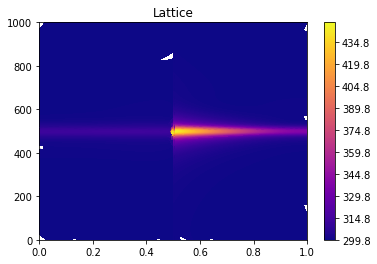

In [ ]:
fig, ax = plt.subplots()
CS = plt.contourf(Xq ,Yq, V_val,800, cmap ='plasma');
plt.cm
ax.clabel(CS, inline=1, fontsize=1)
ax.set_title('Lattice')
plt.colorbar();

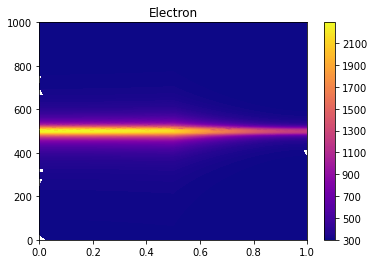

In [ ]:
fig, ax = plt.subplots()
CS = plt.contourf(Xq ,Yq, U_val, 200, cmap ='plasma');
plt.cm
ax.clabel(CS, inline=1, fontsize=1)
ax.set_title('Electron')
plt.colorbar();

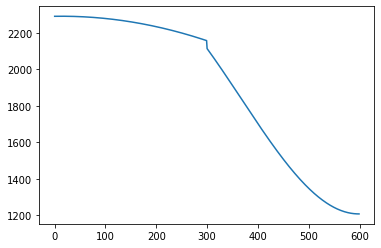

In [ ]:
Z1 = U_val[100,:]
plt.plot(Z1)
plt.savefig('T_e_01centre.jpeg', dpi=300, bbox_inches='tight')

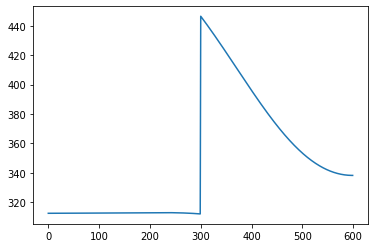

In [ ]:
Z1 = V_val[100,:]
plt.plot(Z1)
plt.savefig('T_e_01centre.jpeg', dpi=300, bbox_inches='tight')

In [ ]:
data = scipy.io.loadmat('newdata_05.mat')
ui = data['uu10'] # based on size of X_star
si = np.transpose(ui)    

In [ ]:
np.savetxt('2delec05.out', U_val, delimiter=',')
np.savetxt('2dlatt05.out', V_val, delimiter=',')

In [ ]:
from google.colab import files
files.download('2delec05.out')
files.download('2dlatt05.out')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>